In [3]:
library(tidyverse)
library(GGally)
library(reshape2)
library(leaps)

## Data Description:
This dataset is obtained from https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset.  
Collected from a popular restaurant over a specified period, this dataset looks into the tipping behavior in a restaurant setting. In this dataset, there are in total 244 observations, and 7 variables.  
Table of variables used:
| Variable Name | Discription | Type |
| :---: | :---: | :---: |
|total_bill| total bill amount in dollars|Numerical, independent variable|
|sex| Gender of the person paying the bill (Male/Female)|Categorical, independent variable|
|smoker|Whether the person is a smoker (Yes/No) |Categorical, independent variable|
|day|Day of the week when the transaction took place (Thur/Fri/Sat/Sun)|Categorical, independent variable|
|time|Time of day when the transaction took place (Lunch/Dinner)|Categorical, independent variable|
|size|Size of the dining party (number of people)|Numerical, independent variable|
|tip|Tip amount in dollars|Numerical, target variable|

## Question:
The reaserch question would be a predictive one:  
Given that a party of 3 on a Friday dinner time with toal bill amount of $30, and the person who pays the bill is a female smoker, what would be the tip amount?

## EDA and Visualization

In [9]:
# 	https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset 
# this reads dataset from my github repo for this project
url <- "https://raw.githubusercontent.com/JustinTrenchcoat/STAT_301_Personal_Project/refs/heads/main/tips.csv"

data_tips <- read.csv(url(url), header = TRUE)
head(data_tips)
ncol <- ncol(data_tips)
norw <- nrow(data_tips)

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
6,25.29,4.71,Male,No,Sun,Dinner,4


To make sure that the only two explanitory variables don't have multicolliniarity problem when using them in our prediction model, we made a correlation matrix heatmap. 

var1,var2,corr
<chr>,<chr>,<dbl>
total_bill,total_bill,1.0000000
total_bill,size,0.5983151
size,total_bill,0.5983151
size,size,1.0000000


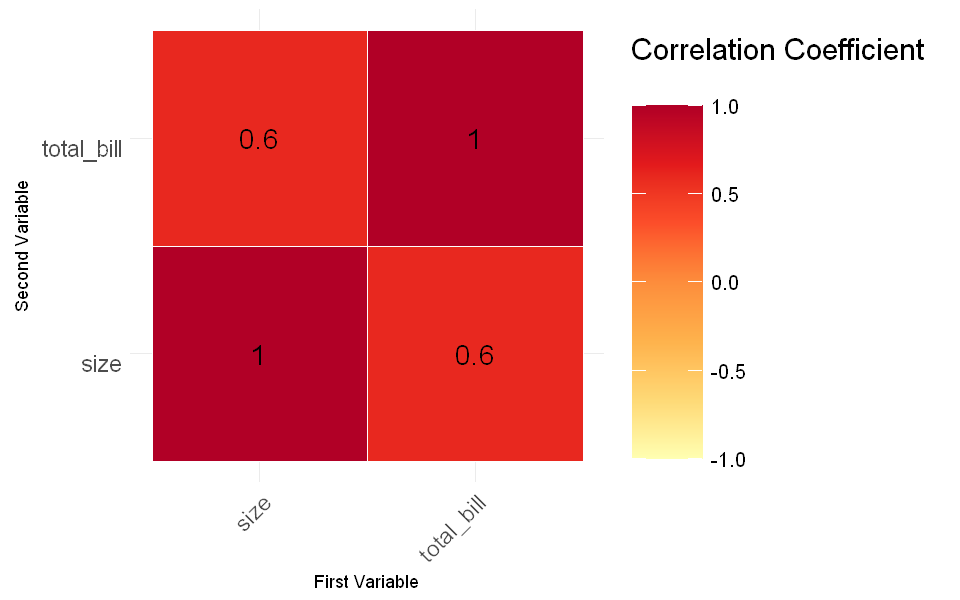

In [5]:
corr_matrix_tip <- 
   data_tips %>%
   select(-sex, -smoker,-day,-time, -tip) |>
   cor() |>
   as_tibble(rownames = 'var1') |>
   pivot_longer(-var1, names_to = "var2", values_to = "corr")

# your code here

corr_matrix_tip
# Adjust these numbers so the plot looks good in your desktop.
options(repr.plot.width = 8, repr.plot.height = 5) 

plot_corr_matrix_tips <- 
  corr_matrix_tip %>%
  ggplot(aes(x=var1, y=var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1,1)
    ) +
    labs(x = "First Variable", y = "Second Variable") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
  geom_text(aes(x=var1, y=var2, label = round(corr, digits=2)), color = "black", size = 6)

# your code here
plot_corr_matrix_tips

## Method and Plan

##### Method:
For this question, I would use multiple linear regression with forward selection for the variable selection process. The tip amount is a continuous variable, so logistic regression would not perform well; and it is not an integer count, so poission regression would not return good result as well.
##### Assumptions
For this selected method, we assume that:  
1. The relation between the tip amount(response) and predictors(size of party and total bill amount) are linear.
2. The errors are independent.
3. The conditional distribution of error term is normal
4. the variance of error terms are equal
5. The model is an additive model, that is, the increase in tip amount per party size or the increase in tip amount per total bill amount is the same, regardless of the day, time, the sex of people who pays the bill or their smoking conditions.
##### Possible Limitation
This model is additive, therefore it would not be able to tell if the change in tip amount associated with the party size/total bill amount is different under different time of a day or the customer's smoking habits. 

## Computational Code

In [6]:
# data splitting
set.seed(123) # DO NOT CHANGE!

data_tips <- 
    data_tips %>%
    mutate(id = row_number())

training_tips <- 
    data_tips %>%
    slice_sample(prop = 0.7, replace = FALSE)

selection_set_tips <- 
    data_tips %>%
    anti_join(training_tips, by = "id")

training_tips <- 
    training_tips %>% 
    select(-"id")

selection_set_tips <- 
    selection_set_tips %>% 
    select(-"id")

# your code here

head(training_tips)
nrow(training_tips)

head(selection_set_tips)
nrow(selection_set_tips)

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,13.39,2.61,Female,No,Sun,Dinner,2
2,26.59,3.41,Male,Yes,Sat,Dinner,3
3,9.60,4.00,Female,Yes,Sun,Dinner,2
4,18.43,3.00,Male,No,Sun,Dinner,4
5,16.58,4.00,Male,Yes,Thur,Lunch,2
6,10.63,2.00,Female,Yes,Sat,Dinner,2


[1] 170

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,14.78,3.23,Male,No,Sun,Dinner,2
4,35.26,5.00,Female,No,Sun,Dinner,4
5,14.83,3.02,Female,No,Sun,Dinner,2
6,16.29,3.71,Male,No,Sun,Dinner,3


[1] 74

In [12]:
tip_forward_sel <- regsubsets(
  x=tip~., 
  nvmax= 8,
  data = selection_set_tips,
  method="forward",
)

tip_forward_sel

tip_fwd_summary <- summary(tip_forward_sel)

tip_fwd_summary_df <- 
    tibble(
        n_input_variables = 1:8,
        RSQ = tip_fwd_summary$rsq,
        RSS = tip_fwd_summary$rss,
        ADJ.R2 = tip_fwd_summary$adjr2
    )

Subset selection object
Call: regsubsets.formula(x = tip ~ ., nvmax = 8, data = selection_set_tips, 
    method = "forward", )
8 Variables  (and intercept)
           Forced in Forced out
total_bill     FALSE      FALSE
sexMale        FALSE      FALSE
smokerYes      FALSE      FALSE
daySat         FALSE      FALSE
daySun         FALSE      FALSE
dayThur        FALSE      FALSE
timeLunch      FALSE      FALSE
size           FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: forward

In [13]:
tip_fwd_summary

Subset selection object
Call: regsubsets.formula(x = tip ~ ., nvmax = 8, data = selection_set_tips, 
    method = "forward", )
8 Variables  (and intercept)
           Forced in Forced out
total_bill     FALSE      FALSE
sexMale        FALSE      FALSE
smokerYes      FALSE      FALSE
daySat         FALSE      FALSE
daySun         FALSE      FALSE
dayThur        FALSE      FALSE
timeLunch      FALSE      FALSE
size           FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: forward
         total_bill sexMale smokerYes daySat daySun dayThur timeLunch size
1  ( 1 ) "*"        " "     " "       " "    " "    " "     " "       " " 
2  ( 1 ) "*"        " "     " "       " "    " "    " "     " "       "*" 
3  ( 1 ) "*"        " "     " "       " "    " "    "*"     " "       "*" 
4  ( 1 ) "*"        " "     " "       "*"    " "    "*"     " "       "*" 
5  ( 1 ) "*"        "*"     " "       "*"    " "    "*"     " "       "*" 
6  ( 1 ) "*"        "*"     "*"       "*"    "

In [18]:
tip_fwd_generative <- lm(tip~total_bill+size+day, data=training_tips)
summary(tip_fwd_generative)


Call:
lm(formula = tip ~ total_bill + size + day, data = training_tips)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8408 -0.5874 -0.0835  0.5133  4.0858 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.87535    0.38067   2.300   0.0227 *  
total_bill   0.09746    0.01141   8.544 8.56e-15 ***
size         0.15114    0.10513   1.438   0.1524    
daySat      -0.36629    0.35857  -1.022   0.3085    
daySun      -0.09536    0.36760  -0.259   0.7956    
dayThur     -0.03904    0.36752  -0.106   0.9155    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.042 on 164 degrees of freedom
Multiple R-squared:  0.4573,	Adjusted R-squared:  0.4408 
F-statistic: 27.64 on 5 and 164 DF,  p-value: < 2.2e-16


In [16]:
tip_test <- lm(tip~total_bill+size+day, data=training_tips)

summary(tip_test)


Call:
lm(formula = tip ~ total_bill + size + day, data = training_tips)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8408 -0.5874 -0.0835  0.5133  4.0858 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.87535    0.38067   2.300   0.0227 *  
total_bill   0.09746    0.01141   8.544 8.56e-15 ***
size         0.15114    0.10513   1.438   0.1524    
daySat      -0.36629    0.35857  -1.022   0.3085    
daySun      -0.09536    0.36760  -0.259   0.7956    
dayThur     -0.03904    0.36752  -0.106   0.9155    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.042 on 164 degrees of freedom
Multiple R-squared:  0.4573,	Adjusted R-squared:  0.4408 
F-statistic: 27.64 on 5 and 164 DF,  p-value: < 2.2e-16


# Citation
Badole, Saurabh. (2025, March). *Restaurant Tips Dataset*. Retrieved from [https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset](https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset)
